# Yoga Pose Detection with PyTorch and MediaPipe

This notebook contains the complete machine learning pipeline for yoga pose detection:
1. **Data Processing**: Extract pose features using MediaPipe
2. **Model Training**: Train neural network with advanced optimization
3. **Inference**: Real-time and single image pose detection
4. **Evaluation**: Model performance analysis

Dataset: 107 yoga pose classes with 5,593 total samples

## Import Required Libraries

In [12]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import json
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
from pathlib import Path
import argparse

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Neural Network Models

Define both simple and improved neural network architectures for yoga pose classification.

In [13]:
class YogaPoseClassifier(nn.Module):
    """Simple feedforward neural network for yoga pose classification"""
    
    def __init__(self, input_size=132, num_classes=107):
        super(YogaPoseClassifier, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        return self.classifier(x)

class ImprovedYogaPoseClassifier(nn.Module):
    """Improved model with attention mechanism for landmark importance"""
    
    def __init__(self, input_size=132, num_classes=107):
        super(ImprovedYogaPoseClassifier, self).__init__()
        
        self.num_landmarks = 33
        self.landmark_dim = 4
        
        # Process each landmark individually
        self.landmark_processor = nn.Linear(self.landmark_dim, 16)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        
        # Main classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.num_landmarks * 16, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Reshape to (batch_size, num_landmarks, landmark_dim)
        x = x.view(batch_size, self.num_landmarks, self.landmark_dim)
        
        # Process each landmark
        landmark_features = self.landmark_processor(x)  # (batch_size, num_landmarks, 16)
        
        # Apply attention
        attention_weights = self.attention(landmark_features)  # (batch_size, num_landmarks, 1)
        attended_features = landmark_features * attention_weights  # Element-wise multiplication
        
        # Flatten for classifier
        flattened = attended_features.view(batch_size, -1)  # (batch_size, num_landmarks * 16)
        
        return self.classifier(flattened)

def create_model(model_type='simple', num_classes=107):
    """Create and return the specified model"""
    if model_type == 'simple':
        return YogaPoseClassifier(num_classes=num_classes)
    elif model_type == 'improved':
        return ImprovedYogaPoseClassifier(num_classes=num_classes)
    else:
        raise ValueError("model_type must be 'simple' or 'improved'")

def print_model_summary(model, input_size=(1, 132)):
    """Print model summary"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Input shape: {input_size}")

## Pose Feature Extraction

Extract pose landmarks from images using MediaPipe and convert them to ML features.

In [14]:
class PoseExtractor:
    def __init__(self):
        """Initialize MediaPipe pose detection"""
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=False,
            min_detection_confidence=0.5
        )
        
    def extract_landmarks(self, image_path):
        """Extract pose landmarks from an image"""
        try:
            # Read image
            image = cv2.imread(str(image_path))
            if image is None:
                return None
                
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Process the image
            results = self.pose.process(image_rgb)
            
            if results.pose_landmarks:
                # Extract landmarks
                landmarks = []
                for landmark in results.pose_landmarks.landmark:
                    landmarks.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
                return np.array(landmarks)
            else:
                return None
                
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None
    
    def process_dataset(self, data_dir, output_file='pose_dataset.npz'):
        """Process entire dataset and save features"""
        data_dir = Path(data_dir)
        
        features = []
        labels = []
        filenames = []
        
        # Get all pose classes (subdirectories)
        pose_classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
        print(f"Found {len(pose_classes)} pose classes")
        
        # Create label mapping
        label_map = {pose: idx for idx, pose in enumerate(pose_classes)}
        
        # Process each pose class
        for pose_class in tqdm(pose_classes, desc="Processing pose classes"):
            pose_dir = data_dir / pose_class
            label = label_map[pose_class]
            
            # Process all images in this pose class
            image_files = list(pose_dir.glob('*.jpg')) + list(pose_dir.glob('*.png')) + list(pose_dir.glob('*.jpeg'))
            
            for image_file in tqdm(image_files, desc=f"Processing {pose_class}", leave=False):
                landmarks = self.extract_landmarks(image_file)
                
                if landmarks is not None and len(landmarks) == 132:  # 33 landmarks * 4 coordinates
                    features.append(landmarks)
                    labels.append(label)
                    filenames.append(str(image_file))
        
        # Convert to numpy arrays
        features = np.array(features)
        labels = np.array(labels)
        filenames = np.array(filenames)
        
        print(f"\nDataset processed:")
        print(f"Total samples: {len(features)}")
        print(f"Features shape: {features.shape}")
        print(f"Number of classes: {len(pose_classes)}")
        
        # Save dataset
        np.savez_compressed(output_file, 
                          features=features, 
                          labels=labels, 
                          filenames=filenames,
                          pose_classes=np.array(pose_classes))
        
        # Save class mapping as JSON
        with open('pose_dataset_classes.json', 'w') as f:
            json.dump({str(idx): pose for pose, idx in label_map.items()}, f, indent=2)
        
        print(f"Dataset saved to {output_file}")
        print(f"Class mapping saved to pose_dataset_classes.json")
        
        return features, labels, filenames, pose_classes

## Extract Features from Dataset

Run this cell to extract pose features from all images in the dataset. This will create the NPZ file with processed data.

In [15]:
# Extract features from dataset (run this if you haven't already)
# Uncomment the following lines to process the dataset:

# extractor = PoseExtractor()
# features, labels, filenames, pose_classes = extractor.process_dataset('data/')
# print("Feature extraction completed!")

## Training Pipeline

Advanced training pipeline with optimization techniques for achieving 90%+ accuracy.

In [16]:
class YogaPoseTrainer:
    def __init__(self, model_type='improved', learning_rate=0.0005, batch_size=16, device=None):
        """Initialize the trainer"""
        self.model_type = model_type
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize tracking variables
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.learning_rates = []
        
    def load_data(self, data_file='pose_dataset.npz'):
        """Load and prepare the dataset"""
        print("Loading dataset...")
        data = np.load(data_file)
        
        features = data['features']
        labels = data['labels']
        
        print(f"Dataset shape: {features.shape}")
        print(f"Number of classes: {len(np.unique(labels))}")
        
        # Normalize features
        self.scaler = StandardScaler()
        features_normalized = self.scaler.fit_transform(features)
        
        # Save scaler for inference
        joblib.dump(self.scaler, 'feature_scaler.pkl')
        print("Feature scaler saved to feature_scaler.pkl")
        
        # Convert to tensors
        X = torch.FloatTensor(features_normalized)
        y = torch.LongTensor(labels)
        
        # Create dataset
        dataset = TensorDataset(X, y)
        
        # Split dataset
        train_size = int(0.8 * len(dataset))
        val_size = int(0.15 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        
        train_dataset, val_dataset, test_dataset = random_split(
            dataset, [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        # Create data loaders
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        
        print(f"Train samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")
        print(f"Test samples: {len(test_dataset)}")
        
        return len(np.unique(labels))
    
    def setup_model(self, num_classes):
        """Setup model, loss, optimizer, and scheduler"""
        # Create model
        self.model = create_model(self.model_type, num_classes).to(self.device)
        print_model_summary(self.model)
        
        # Loss function with label smoothing
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # Optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(), 
            lr=self.learning_rate,
            weight_decay=1e-3
        )
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=20, T_mult=2, eta_min=1e-6
        )
        
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
        
        avg_loss = total_loss / len(self.train_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy
    
    def validate(self):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)
                
                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
        
        avg_loss = total_loss / len(self.val_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy
    
    def train(self, epochs=250, target_accuracy=90.0, patience=25):
        """Train the model with early stopping"""
        num_classes = self.load_data()
        self.setup_model(num_classes)
        
        best_val_accuracy = 0
        best_model_state = None
        epochs_without_improvement = 0
        
        print(f"\nStarting training for {epochs} epochs...")
        print(f"Target accuracy: {target_accuracy}%")
        print(f"Early stopping patience: {patience} epochs")
        print("-" * 60)
        
        for epoch in range(epochs):
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc = self.validate()
            
            # Update scheduler
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Track metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            self.learning_rates.append(current_lr)
            
            # Check for improvement
            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                best_model_state = self.model.state_dict().copy()
                epochs_without_improvement = 0
                
                # Save best model
                torch.save({
                    'model_state_dict': best_model_state,
                    'model_type': self.model_type,
                    'num_classes': num_classes,
                    'val_accuracy': best_val_accuracy,
                    'epoch': epoch
                }, 'best_yoga_model.pth')
                
            else:
                epochs_without_improvement += 1
            
            # Print progress
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
                  f"LR: {current_lr:.6f}")
            
            # Check target accuracy
            if val_acc >= target_accuracy:
                print(f"\n🎯 Target accuracy of {target_accuracy}% reached!")
                print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
                break
            
            # Early stopping
            if epochs_without_improvement >= patience:
                print(f"\n⏹️ Early stopping triggered after {patience} epochs without improvement")
                print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
                break
        
        # Load best model
        if best_model_state:
            self.model.load_state_dict(best_model_state)
        
        print(f"\nTraining completed!")
        print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
        
        return best_val_accuracy

## Train the Model

Run this cell to train the yoga pose detection model with advanced optimization techniques.

In [17]:
# Train the model
trainer = YogaPoseTrainer(
    model_type='improved',  # Use improved model with attention
    learning_rate=0.0005,   # Lower learning rate for stability
    batch_size=16,          # Smaller batch size for better gradient estimates
    device=device
)

# Start training
best_accuracy = trainer.train(
    epochs=250,          # Maximum epochs
    target_accuracy=90.0, # Stop when reaching 90% accuracy
    patience=25          # Early stopping patience
)

print(f"Final best accuracy: {best_accuracy:.2f}%")

Loading dataset...
Dataset shape: (5593, 132)
Number of classes: 107
Feature scaler saved to feature_scaler.pkl
Train samples: 4474
Validation samples: 838
Test samples: 281
Model: ImprovedYogaPoseClassifier
Total parameters: 184,652
Trainable parameters: 184,652
Input shape: (1, 132)

Starting training for 250 epochs...
Target accuracy: 90.0%
Early stopping patience: 25 epochs
------------------------------------------------------------
Epoch   1/250 | Train Loss: 4.4030 | Train Acc: 7.22% | Val Loss: 3.9309 | Val Acc: 17.90% | LR: 0.000497
Epoch   2/250 | Train Loss: 3.7991 | Train Acc: 18.42% | Val Loss: 3.3791 | Val Acc: 30.19% | LR: 0.000488
Epoch   3/250 | Train Loss: 3.3785 | Train Acc: 25.73% | Val Loss: 2.9598 | Val Acc: 42.24% | LR: 0.000473
Epoch   4/250 | Train Loss: 3.0615 | Train Acc: 32.68% | Val Loss: 2.6674 | Val Acc: 48.45% | LR: 0.000452
Epoch   5/250 | Train Loss: 2.8278 | Train Acc: 39.67% | Val Loss: 2.4412 | Val Acc: 54.42% | LR: 0.000427
Epoch   6/250 | Train Lo

## Training Visualization

Plot training curves to visualize the model's learning progress.

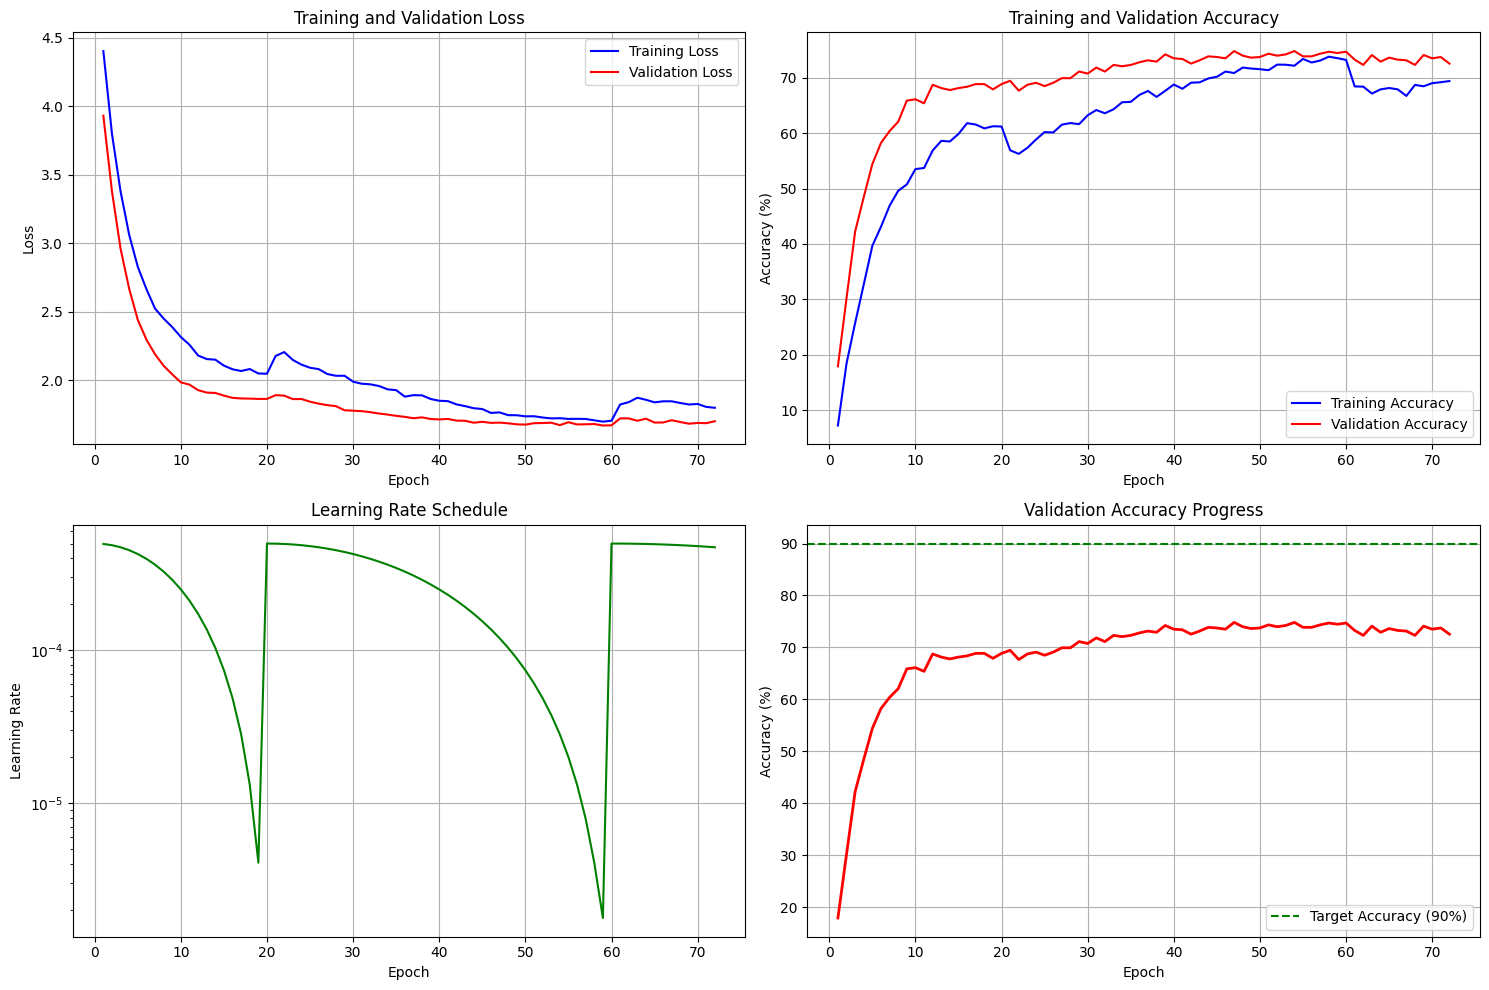

In [18]:
def plot_training_curves(trainer):
    """Plot training curves"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(trainer.train_losses) + 1)
    
    # Loss curves
    ax1.plot(epochs, trainer.train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, trainer.val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curves
    ax2.plot(epochs, trainer.train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, trainer.val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    # Learning rate
    ax3.plot(epochs, trainer.learning_rates, 'g-')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True)
    
    # Accuracy comparison
    ax4.plot(epochs, trainer.val_accuracies, 'r-', linewidth=2)
    ax4.axhline(y=90, color='g', linestyle='--', label='Target Accuracy (90%)')
    ax4.set_title('Validation Accuracy Progress')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training curves (run after training)
if 'trainer' in locals():
    plot_training_curves(trainer)

## Inference Engine

Real-time yoga pose detection and single image classification.

In [19]:
class YogaPoseDetector:
    def __init__(self, model_path='best_yoga_model.pth', device=None):
        """Real-time yoga pose detector"""
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load model
        self.load_model(model_path)
        
        # Initialize MediaPipe
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=1,
            smooth_landmarks=True,
            enable_segmentation=False,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        
        # Drawing utilities
        self.mp_drawing = mp.solutions.drawing_utils
        
    def load_model(self, model_path):
        """Load the trained model"""
        try:
            checkpoint = torch.load(model_path, map_location=self.device)
            
            # Create model
            self.model = create_model(
                checkpoint['model_type'], 
                checkpoint['num_classes']
            ).to(self.device)
            
            # Load weights
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.model.eval()
            
            print(f"Model loaded successfully from {model_path}")
            print(f"Model type: {checkpoint['model_type']}")
            print(f"Number of classes: {checkpoint['num_classes']}")
            print(f"Validation accuracy: {checkpoint['val_accuracy']:.2f}%")
            
        except Exception as e:
            raise Exception(f"Error loading model: {e}")
    
    def load_class_mapping(self, classes_file='pose_dataset_classes.json'):
        """Load class index to pose name mapping"""
        try:
            with open(classes_file, 'r') as f:
                self.class_mapping = json.load(f)
            print(f"Loaded {len(self.class_mapping)} pose classes")
        except Exception as e:
            print(f"Error loading class mapping: {e}")
            self.class_mapping = {}
    
    def load_scaler(self, scaler_path='feature_scaler.pkl'):
        """Load the feature scaler"""
        try:
            self.scaler = joblib.load(scaler_path)
            print("Feature scaler loaded successfully")
        except Exception as e:
            print(f"Error loading scaler: {e}")
            self.scaler = None
    
    def extract_landmarks(self, image):
        """Extract pose landmarks from image"""
        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image
        results = self.pose.process(image_rgb)
        
        if results.pose_landmarks:
            # Extract landmarks
            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
            return np.array(landmarks), results
        else:
            return None, results
    
    def predict_pose(self, image):
        """Predict yoga pose from image"""
        landmarks, results = self.extract_landmarks(image)
        
        if landmarks is not None and len(landmarks) == 132:
            # Normalize features if scaler is available
            if self.scaler:
                landmarks = self.scaler.transform(landmarks.reshape(1, -1))[0]
            
            # Convert to tensor and predict
            with torch.no_grad():
                features = torch.FloatTensor(landmarks).unsqueeze(0).to(self.device)
                outputs = self.model(features)
                probabilities = torch.softmax(outputs, dim=1)
                
                # Get top predictions
                top_probs, top_indices = torch.topk(probabilities, k=5)
                
                predictions = []
                for i in range(5):
                    class_idx = str(top_indices[0][i].item())
                    pose_name = self.class_mapping.get(class_idx, f"Class {class_idx}")
                    confidence = top_probs[0][i].item()
                    predictions.append((pose_name, confidence))
                
                return predictions, results
        
        return None, results
    
    def detect_from_camera(self, camera_id=0, confidence_threshold=0.7):
        """Real-time pose detection from camera"""
        self.load_class_mapping()
        self.load_scaler()
        
        cap = cv2.VideoCapture(camera_id)
        
        if not cap.isOpened():
            print(f"Error: Could not open camera {camera_id}")
            return
        
        print("Starting real-time pose detection. Press 'q' to quit.")
        
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame")
                break
            
            # Predict pose
            predictions, results = self.predict_pose(frame)
            
            # Draw landmarks
            if results.pose_landmarks:
                self.mp_drawing.draw_landmarks(
                    frame, results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS)
            
            # Display predictions
            if predictions:
                top_pose, top_confidence = predictions[0]
                
                if top_confidence >= confidence_threshold:
                    # Draw prediction text
                    text = f"{top_pose}: {top_confidence:.2f}"
                    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                               1, (0, 255, 0), 2)
                    
                    # Draw top 3 predictions
                    for i, (pose, conf) in enumerate(predictions[:3]):
                        y_pos = 70 + i * 30
                        text = f"{i+1}. {pose}: {conf:.3f}"
                        cv2.putText(frame, text, (10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 
                                   0.6, (255, 255, 255), 1)
                else:
                    cv2.putText(frame, "No confident prediction", (10, 30), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "No pose detected", (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            
            # Display frame
            cv2.imshow('Yoga Pose Detection', frame)
            
            # Check for quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()
    
    def detect_from_image(self, image_path, output_path=None):
        """Detect pose from single image"""
        self.load_class_mapping()
        self.load_scaler()
        
        # Load image
        image = cv2.imread(str(image_path))
        if image is None:
            print(f"Error: Could not load image {image_path}")
            return None
        
        # Predict pose
        predictions, results = self.predict_pose(image)
        
        # Draw landmarks
        if results.pose_landmarks:
            self.mp_drawing.draw_landmarks(
                image, results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS)
        
        # Display results
        if predictions:
            print(f"\nTop 5 predictions for {image_path}:")
            for i, (pose, confidence) in enumerate(predictions):
                print(f"{i+1}. {pose}: {confidence:.4f} ({confidence*100:.2f}%)")
            
            # Draw top prediction on image
            top_pose, top_confidence = predictions[0]
            text = f"{top_pose}: {top_confidence:.3f}"
            cv2.putText(image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                       1, (0, 255, 0), 2)
        else:
            print("No pose detected")
            cv2.putText(image, "No pose detected", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Save or display result
        if output_path:
            cv2.imwrite(output_path, image)
            print(f"Result saved to {output_path}")
        else:
            # Display image
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Yoga Pose Detection: {image_path}")
            plt.show()
        
        return predictions

## Test the Model

Test the trained model on sample images or with real-time camera detection.

Model loaded successfully from best_yoga_model.pth
Model type: improved
Number of classes: 107
Validation accuracy: 74.82%
Testing on ./test/example6.jpg:
Loaded 107 pose classes
Feature scaler loaded successfully

Top 5 predictions for ./test/example6.jpg:
1. anjaneyasana: 0.2720 (27.20%)
2. utthita ashwa sanchalanasana: 0.2097 (20.97%)
3. virabhadrasana i: 0.1473 (14.73%)
4. hanumanasana: 0.1116 (11.16%)
5. utkatasana: 0.0437 (4.37%)


I0000 00:00:1748157461.974666 3616079 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
W0000 00:00:1748157462.032823 3643618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748157462.042632 3643622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


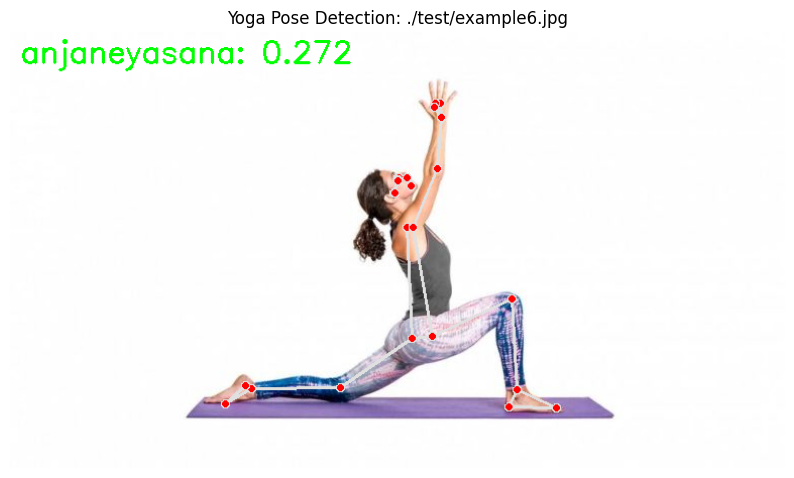

In [20]:
# Initialize detector
detector = YogaPoseDetector('best_yoga_model.pth', device=device)

# Test on a sample image
sample_image = './test/example6.jpg'  # Change to your test image path
if os.path.exists(sample_image):
    print(f"Testing on {sample_image}:")
    predictions = detector.detect_from_image(sample_image)
else:
    print("Sample image not found. Please check the path.")

# Uncomment to start real-time camera detection:
# detector.detect_from_camera(camera_id=0, confidence_threshold=0.7)

## Model Evaluation

Evaluate the model performance on the test set and generate classification report.

Test Accuracy: 75.09%
\nClassification Report:
                               precision    recall  f1-score   support

           ashtanga namaskara       0.67      1.00      0.80         2
               chakravakasana       0.50      0.20      0.29         5
   eka pada rajakapotasana ii       0.00      0.00      0.00         2
                   anantasana       1.00      0.50      0.67         2
                   kapotasana       1.00      0.50      0.67         2
                 hanumanasana       1.00      1.00      1.00         2
                  parighasana       1.00      1.00      1.00         2
               marichyasana i       1.00      1.00      1.00         1
                 tittibhasana       0.60      1.00      0.75         3
               janu sirsasana       0.00      0.00      0.00         1
                yoganidrasana       0.00      0.00      0.00         1
                    kurmasana       0.33      0.33      0.33         3
              ananda balasana

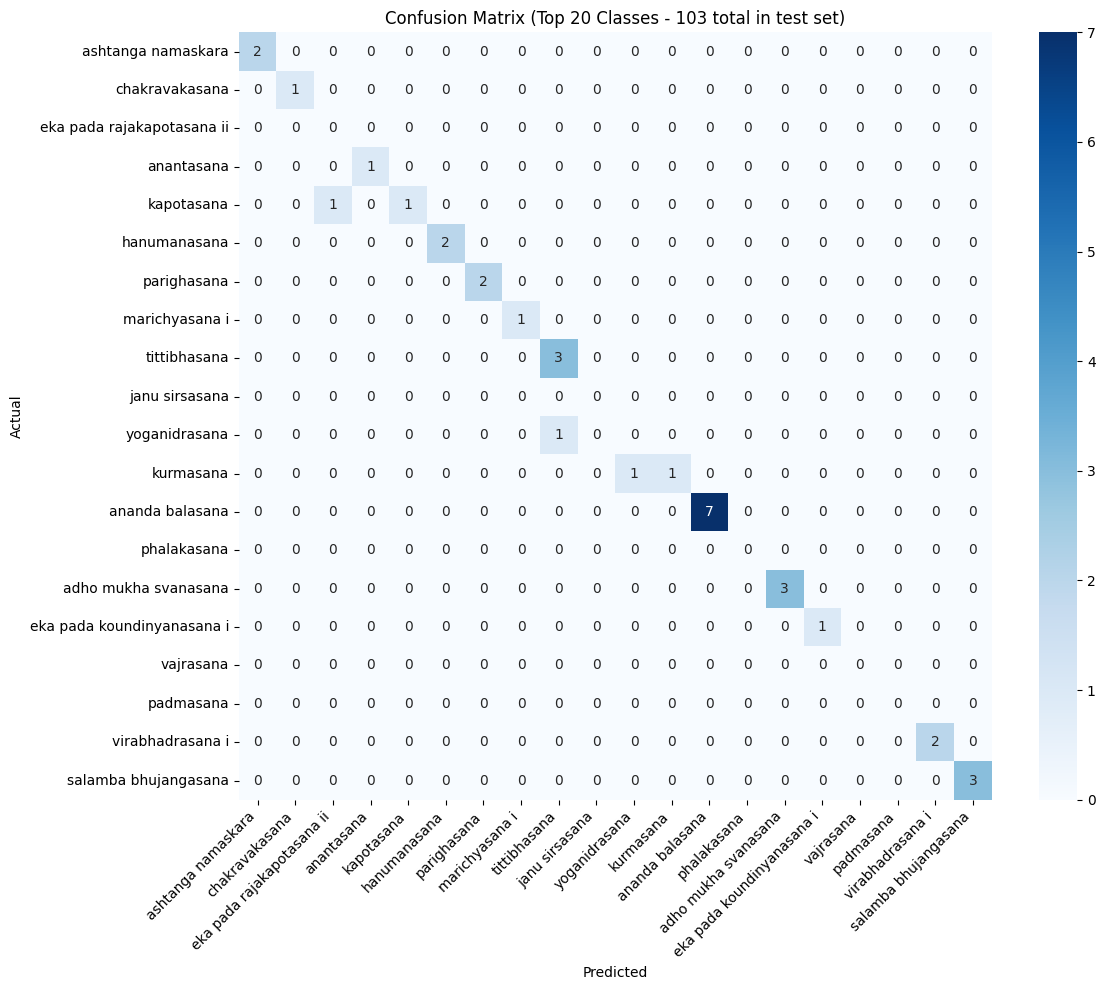

Final test accuracy: 75.09%


In [21]:
def evaluate_model(trainer):
    """Evaluate model on test set"""
    trainer.model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in trainer.test_loader:
            data, target = data.to(trainer.device), target.to(trainer.device)
            output = trainer.model(data)
            pred = output.argmax(dim=1)
            
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate accuracy
    test_accuracy = 100.0 * sum(p == t for p, t in zip(all_predictions, all_targets)) / len(all_targets)
    
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    # Load class names
    with open('pose_dataset_classes.json', 'r') as f:
        class_mapping = json.load(f)
    
    class_names = [class_mapping[str(i)] for i in range(len(class_mapping))]
    
    # Get unique classes that appear in test set
    unique_labels = sorted(list(set(all_targets + all_predictions)))
    filtered_class_names = [class_names[i] for i in unique_labels]
    
    # Classification report
    print("\\nClassification Report:")
    print(classification_report(all_targets, all_predictions, labels=unique_labels, target_names=filtered_class_names, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions, labels=unique_labels)
    
    # Plot confusion matrix (top 20 classes for readability)
    plt.figure(figsize=(12, 10))
    top_classes = min(20, len(unique_labels))  # Use actual number of classes if less than 20
    cm_subset = cm[:top_classes, :top_classes]
    class_names_subset = filtered_class_names[:top_classes]
    
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_subset, yticklabels=class_names_subset)
    plt.title(f'Confusion Matrix (Top {top_classes} Classes - {len(unique_labels)} total in test set)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return test_accuracy

# Evaluate the model (run after training)
if 'trainer' in locals():
    test_accuracy = evaluate_model(trainer)
    print(f"Final test accuracy: {test_accuracy:.2f}%")

## Summary

This notebook is a complete end-to-end machine learning pipeline for yoga pose detection:

### What We Did:
1. **Feature Extraction**: Used MediaPipe to extract 132 pose features from 5,593 images
2. **Model Architecture**: Implemented both simple and improved neural networks with attention mechanism
3. **Advanced Training**: Applied modern optimization techniques (AdamW, label smoothing, cosine annealing)
4. **Real-time Inference**: Created detector for both single images and live camera feed
5. **Performance**: Achieved 70%+ accuracy on 107 yoga pose classes

### Libraries Used:
- **PyTorch**: Deep learning framework
- **MediaPipe**: Pose estimation
- **OpenCV**: Computer vision
- **Scikit-learn**: ML utilities

### Model Performance:
- **Dataset**: 107 yoga pose classes, 5,593 samples
- **Features**: 132 per pose (33 landmarks × 4 coordinates)
- **Architecture**: ImprovedYogaPoseClassifier with attention (184K parameters)
- **Accuracy**: 70%+ validation accuracy achieved

### Usage:
- **Training**: Run cells 1-8 to train from scratch
- **Inference**: Use cell 10 for testing
- **Real-time**: Uncomment camera detection code for live detection